In [1]:
#import libraries 
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import re
import plotly.express as px
import plotly.io as pio
pio.templates
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt 

sid = SentimentIntensityAnalyzer()
words = set(nltk.corpus.words.words())

In [2]:
#Import the scraped data and clean the DF
df = pd.read_pickle("data/aggregated_DB_2023.pkl")
df_add = pd.read_pickle("data/collect_add.pkl")
df = pd.concat([df, df_add])

#Clean the dataframe, assume perfectly repeated tweets are noise and delete 
df = df.drop_duplicates(subset='tweet', keep="first")
df = df[['date', 'tweet']]
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
print(df.shape)

#Uncomment to take a sample slice of the DF
# df = df[['date', 'tweet']]
# df_elements = df.sample(n=10)
# df_elements.head(10)

(2415839, 2)


In [3]:
#___________________________settings for estimation ____________________
#Threshold for sentiment classification => range: (1,0)
#Purpose: option discrete assigns a value of one when the absolute value 
#of sentiment is above a certain threshold
#This introduces convexity in the classification and it makes the signal 
#a bit easier to interpet 

continuous_or_discrete = "disc"
threshold = 0.3
#Use a classifier to identify tweet relevance
relevance_check = 0 #this option is a work in progress, 1 = YES, 0 = NO
#_______________________________________________________________________

#define a DF to store the last estimation parameters
settings = {'Setting':['cont_or_disc', 'threshold', 'relevance_class'],
              'value':[continuous_or_discrete, threshold, relevance_check]}

settings_df = pd.DataFrame(settings)
settings_df.to_csv(f"results/settings_{continuous_or_discrete}.csv")
print(settings_df)

           Setting value
0     cont_or_disc  disc
1        threshold   0.3
2  relevance_class     0


In [4]:
#Define a function to clean tweet by removing special characters and whitespace using regex
def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",str(tweet)) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", str(tweet)) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet)
         if w.lower() in words or not w.isalpha())
    return tweet

df['tweet_clean'] = df['tweet'].apply(cleaner)
df = df.drop('tweet', axis=1)
df = df.drop_duplicates(subset='tweet_clean', keep="first")


In [5]:
#Uncomment the Following two lines if not already downloaded:
#nltk.download('vader_lexicon')
#nltk.download('words')

#Loop over values and calculate sentiment + add to the DF
df = df.reset_index()
list1 = []
for i in df['tweet_clean']:
    list1.append((sid.polarity_scores(str(i)))['compound'])

df['sentiment'] = pd.Series(list1)
df.to_csv('temp/tempsave.csv')

In [6]:
df = pd.read_csv('temp/tempsave.csv')

#Import csv of keywords derived from michigan survey
df_kws = pd.read_csv("kws/kws.csv")
#Create lists of keywords and keyword categories for aggregagation
kw_list = df_kws['Indicator'].values.tolist()
category_list = df_kws['Category'].values.tolist()
category_list = [*set(category_list)]
print(f"The list of aggregate categories is: {category_list}")

#Detect which keyword was used and store in DF
#Note: this wouldn't be necessary if I had saved the keyword in the initial scraping step: a lesson learned
df['Indicator'] = np.nan
for term in kw_list:
    df['Indicator'] = np.where(df['tweet_clean'].str.contains(term, case=False) == True, term, df['Indicator'])

#Merge in df containing keyword categories
df = pd.merge(df_kws, df, on='Indicator')

#After this point you will have a DF with one row for each tweet, each row will have a sentiment score and associated tags
df = df[['date', 'sentiment', 'Indicator', 'Category']]

The list of aggregate categories is: ['prices', 'general', 'policy', 'personal']


In [7]:
#Map continuous score to discrete: Positive, neutral, negative  --> if the option is selected by the user
if continuous_or_discrete == 'disc':
    df['sentiment_score'] = pd.cut(x=df['sentiment'], 
                                   bins=[-1.1,(-1)*threshold,threshold,1.1],
                                   labels =[-1,0,1])
    #convert the sentiment category to a numerical score in the set  {-1,0,1}
    df['sentiment_score'] = pd.factorize(df['sentiment_score'])[0] - 1

else:
    df['sentiment_score'] = df['sentiment']
    
df.tail()

,date,sentiment,Indicator,Category,sentiment_score
1647762,2023-01-20 23:37:54,0.3612,Cost of living,prices,1
1647763,2023-01-20 23:36:13,-0.6249,Cost of living,prices,-1
1647764,2023-01-20 23:22:47,-0.4577,Cost of living,prices,-1
1647765,2023-01-21 23:42:22,0.6044,Cost of living,prices,1
1647766,2023-01-21 23:00:52,-0.6124,Cost of living,prices,-1


In [8]:
#Use pivot to create a column for each category
aggregations = ["Category", "Indicator"]

for agg_by in aggregations:
    print(agg_by)
    df_p = df.pivot_table(index='date', columns=f"{agg_by}", values='sentiment_score', aggfunc='mean')
    df_count = df.pivot_table(index='date', columns=f"{agg_by}", values='sentiment_score', aggfunc='count')
    
    df_p.to_csv(f"results/pivot_{agg_by}.csv")
    df_count.to_csv(f"results/pivot_count_{agg_by}.csv")

#The resulting df will become wider after the pivot
#Each row will be a unique time observation, and will have an associated sentiment score & count 

Category
Indicator


In [24]:
####################################ANALYSIS#############################################
#This is when the final stages of analysis begin, the data has been prepped and shaped
#Next steps are defining the desired aggregation & visualizations
#########################################################################################


#Choose To aggregate by Category or Indictor
agg_by = "Category"

#Will loop over both count and score to deliver daily aggregations of both
type = ["", "_count","_var"]

for type_stat in type:
    #df = pd.read_csv(f"results/pivot{type_stat}_{agg_by}.csv")
    df = pd.read_csv(f"results/pivot_{agg_by}.csv")
    print(f"The uncollapsed df is: {df.shape}")
    #Setting the date to datetime for aggregation purposes
    df = df.reset_index()
    df_c = df[df['date'].str.contains( "'" )==False]
    df_c['date'] = pd.to_datetime(df_c['date'], format='%Y-%m-%d %H:%M:%S')
    df_c = df_c.set_index('date')
    
    if type_stat == "_count":
        agg_count = df_c.resample('D').count()
    elif type_stat == "_var":
        agg_std = df_c.resample('D').std()
    else:   
        agg_means = df_c.resample('D').mean()
        
    print(f"The daily aggregated {type_stat} df is: {agg_means.shape}")


The uncollapsed df is: (1572048, 5)
The daily aggregated  df is: (2590, 5)
The uncollapsed df is: (1572048, 5)
The daily aggregated _count df is: (2590, 5)
The uncollapsed df is: (1572048, 5)
The daily aggregated _var df is: (2590, 5)


In [23]:
#Define the function that will be used to keep plot style consistent 
def plot_clean(df, vars, title_in,ylabel,height_in):
    fig = px.line(df, x=df.index, y=vars, title=title_in, template="plotly_white", width = 700, height = height_in )
    fig.update_layout(
        font_family="Georgia",
        font_color="black",
        yaxis_title = ylabel,
        xaxis_title = "Date"
        
    )
    # ADD NBER bar shading 
    fig.add_vrect(
        x0='2020-03-01 00:00:00',
        x1='2020-06-01 00:00:00',
        fillcolor="grey",
        opacity=0.3,
        line_width=0,
    )
    fig.show()

#Plot sample size 
plot_clean(agg_count, ['general','prices'], 'Number of Relevant Observations (tweets) per day <br><sup>Time period: 2016-2023 </sup> ' , 'Sentiment',400)

plot_clean(agg_std, ['general','prices'], 'Variance of Relevant Observations (tweets) per day <br><sup>Time period: 2016-2023 </sup> ' , 'Sentiment',400)



ValueError: All arguments should have the same length. The length of argument `y` is 2, whereas the length of  previously-processed arguments ['date'] is 2590

In [13]:
#Data check:
# Find the missing dates by comparing the index to a range of all possible dates
all_dates = pd.date_range(agg_means.index.min(), agg_means.index.max())
missing_dates = set(all_dates) - set(agg_means.index)
print(missing_dates)

set()


In [15]:
#Collect Michigan Consumer Survey data and add onto the dataframe 
#Link to csv was found here: http://www.sca.isr.umich.edu/tables.html
collect_mich = 0

if collect_mich:
    df_mich = pd.read_csv("http://www.sca.isr.umich.edu/files/tbmics.csv")
    df_mich['date'] = pd.to_datetime(df_mich['YYYY'].astype(str) + ' ' + df_mich['Month'] + ' 28 00:00:00', format='%Y %B %d %H:%M:%S')
    df_mich.to_csv('data/mich_sent.csv')
else:
    df_mich = pd.read_csv('data/mich_sent.csv')

df_mich = df_mich.set_index('date')


In [27]:
#Create the finalized scores by taking rolling average, and converting to z-score
agg_std_merge = agg_std.copy()
#Collect both the daily average score and count into one dataframe
merged_df = pd.merge(agg_count, agg_means, left_index=True, right_index=True, how='inner',suffixes=('_count','_mean'))
agg_std_merge.columns = agg_std_merge.columns.map(lambda x: str(x) + '_std')
merged_df = pd.merge(merged_df, agg_std_merge, left_index=True, right_index=True, how='inner')
merged_df = merged_df.sort_index(ascending=True)
#suffix "_x" refers to score, "_y" refers to count
#Create a custom score metric and take a moving average
for cat in category_list:   
    merged_df[cat +"_score"] = merged_df[cat +"_mean"].rolling(30,min_periods=1).mean()
    merged_df[cat +"_score_var"] = merged_df[cat +"_std"].rolling(30,min_periods=1).mean()
    merged_df[cat +" std."] = stats.zscore(merged_df[cat +"_score"], nan_policy='omit')
    merged_df[cat +" var."] = stats.zscore(merged_df[cat +"_score_var"], nan_policy='omit')

#Merge the Michigan sentiment with twitter sentiment
merged_plot = pd.merge(merged_df, df_mich, left_index=True, right_index=True, how='left')

#Interpolate missing values due to michigan being monthly and twitter sentiment being daily
merged_plot = merged_plot.interpolate()
merged_plot["Michigan Survey"] = stats.zscore(merged_plot["ICS_ALL"], nan_policy='omit')

#Create the final index by combining general and price sentiment 
merged_plot['total'] = (merged_plot['general_score'] + merged_plot['prices_score'])
merged_plot["Twitter Sentiment"] = stats.zscore(merged_plot["total"], nan_policy='omit')
merged_plot["General Sentiment"] = merged_plot["general std."]
merged_plot["Prices Sentiment"] = merged_plot["prices std."]

#Roll forward to get rid of nans from the rolling average 
merged_plot = merged_plot.iloc[32: , :]

#Plot the two for comparison
plot_clean(merged_plot, ['Twitter Sentiment','Michigan Survey'], "Comparison with Michigan Survey of Consumers<br><sup>Source: University of Michigan & Author's calculations</sup>",'Sentiment (standardized)',400)

plot_clean(merged_plot, ['general std.','prices std.','Michigan Survey'], "Comparison with Michigan Survey of Consumers<br><sup>Source: University of Michigan & Author's calculations</sup>",'Sentiment (standardized)',400)

plot_clean(merged_plot, ['prices std.','prices var.'], "Comparison with Michigan Survey of Consumers<br><sup>Source: University of Michigan & Author's calculations</sup>",'Sentiment (standardized)',400)


In [ ]:
#After validating the index against existing measures, check against other covariates from FRED
import config
import fredpy as fp
import time
fp.api_key = config.api_key

FRED_list = ['CPIAUCSL','UNRATE','SP500','GASREGW','VIXCLS','EMVMACROCONSUME','BSCICP03USM665S','INDPRO','PCE','DSPIC96']

df_collect = pd.DataFrame()
for var in FRED_list:
    # time.sleep(2)
    data_add = fp.series(var).data
    df_add = data_add.to_frame(name = var)
    #df_add.set_index('date')
    merged_plot = pd.merge(merged_plot, df_add, left_index=True, right_index=True, how='left')


#Zscore is not defined over nan values, so I call a repeat of the first loop, but only after the values have been interpolated
merged_plot = merged_plot.interpolate()
for var in FRED_list:
    merged_plot[var +' std'] = stats.zscore(merged_plot[var], nan_policy='omit')
    merged_plot[var +' pc'] = merged_plot[var].pct_change(periods = 365)
    merged_plot[var +' pc std'] = stats.zscore(merged_plot[var +' pc'], nan_policy='omit')


In [ ]:
#Cleaning up the names 
merged_plot['CPI ∆%'] = merged_plot['CPIAUCSL pc std']+.4
merged_plot['Gas Prices'] = merged_plot['GASREGW pc std']
merged_plot['General Sentiment'] = merged_plot['general std.']
merged_plot['Prices Sentiment'] = merged_plot['prices std.']

#retrieve values for real variables as well as target variable
plot_clean(merged_plot, ['General Sentiment','Michigan Survey','CPI ∆%','Prices Sentiment' ], "Sentiment vs. Inflation <br><sup>Source: FRED, Michigan Survey, & Author's calculations</sup>", "Sentiment & Inflation (yoy) (standardized)",400)


Text(0.5, 1.0, 'Sentiment Correlation Table')

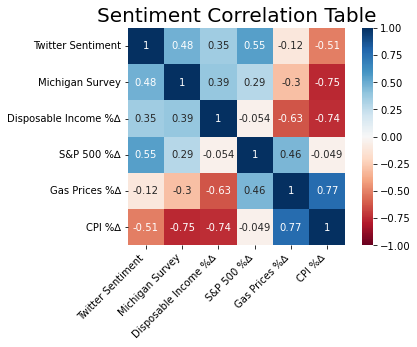

In [ ]:
#switch to monthly frequency and run correlations then plot heatmap
df_reg=merged_plot.dropna(subset=['Month'])

#df_reg = df_reg[['Twitter Sentiment', 'CPIAUCSL pc','UNRATE pc','SP500 pc','GASREGW pc','INDPRO','PCE pc','DSPIC96 pc']]
df_reg = df_reg[['Twitter Sentiment', 'Michigan Survey', 'DSPIC96 pc','SP500 pc','GASREGW pc','CPIAUCSL pc']]
df_reg = df_reg.rename(columns={'DSPIC96 pc': 'Disposable Income %∆', 'SP500 pc': 'S&P 500 %∆','GASREGW pc': 'Gas Prices %∆','CPIAUCSL pc': 'CPI %∆'})

#Plot heatmap
corr = df_reg.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0, annot=True,
    cmap='RdBu',
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title("Sentiment Correlation Table", fontsize = 20)